---
---

# **Qubit-based quantum autoencoder**

This script stores the code related to the **qubit-based quantum autoencoder** that we have replicated following the data in the paper ‘https://arxiv.org/abs/2502.17301’ and that we have used to compare and analyse the results of our model based on qubits.

---
---

In [ ]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm


## Section: Data loading and processing

This code loads multiple JSON files containing jet events, selects the top constituents by transverse momentum ($p_T$) for each jet, and computes their kinematic variables ($p_T$, $\eta$, $\phi$) for further analysis.

### **Loading trainning real data**

In [ ]:
datos = []
def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, _ = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calculate pT for each constituent
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Indices of the top 10 constituents by pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convert each one to the format used in the circuit
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            pt = np.sqrt(px**2 + py**2)
            eta = 0.5 * np.log((E + pz) / (E - pz + 1e-8))  # avoid division by zero
            phi = np.arctan2(py, px)
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'constituents': top_constituents
        })

    return eventos

datos_1 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_jetpt500_1000.json')
datos_2 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch1_jetpt500_1000.json')
datos_3 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch10_jetpt500_1000.json')
datos_5 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch12_jetpt500_1000.json')
datos_6 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch13_jetpt500_1000.json')
datos_7 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch14_jetpt500_1000.json')
datos_8 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch16_jetpt500_1000.json')
datos_9 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch17_jetpt500_1000.json')
datos_10 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch18_jetpt500_1000.json')
datos = datos_1 + datos_2 + datos_3 + datos_5 + datos_6 + datos_7 + datos_8 + datos_9 + datos_10  

### **Loading simulated CMS data** (physical signals mostly for inference step)

In [ ]:

def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract jet kinematics
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        jet_energy = evento.get('jet_energy', i)
        jet_tau1 = evento.get('jet_tau1', i)
        jet_tau2 = evento.get('jet_tau2', i)
        jet_tau3 = evento.get('jet_tau3', i)    
        jet_tau4 = evento.get('jet_tau4', i)

        jet_tau12 = jet_tau1 / jet_tau2 if jet_tau2 != 0 else 0
        jet_tau23 = jet_tau2 / jet_tau3 if jet_tau3 != 0 else 0
        jet_tau34 = jet_tau3 / jet_tau4 if jet_tau4 != 0 else 0

        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        part_d0val = np.array(evento.get('part_d0val', []))
        part_dzval = np.array(evento.get('part_dzval', []))
        
        # Calculate pT, eta, phi, mass for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        eta = 0.5 * np.log((p_total + part_pz) / (p_total - part_pz + 1e-8))  # Avoiding dividing by 0
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx],
                'energy': part_energy[idx],
                'd0': part_d0val[idx],
                'dz': part_dzval[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'tau1_jet': jet_tau1,
            'tau2_jet': jet_tau2,
            'tau3_jet': jet_tau3,
            'tau4_jet': jet_tau4,
            'tau12_jet': jet_tau12,
            'tau23_jet': jet_tau23,
            'tau34_jet': jet_tau34,
            'constituents': top_constituents
        })

    return eventos

datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120_flat.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120_flat.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120_flat.json', num_jets=10000, num_constituents=10)
datos_QCD_simu_1 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_2 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_121_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_full = datos_QCD_simu_1 + datos_QCD_simu_2

## **Section**: Splitting data into train, validation, and inference sets

This code converts the dataset into a NumPy array and splits it into three parts: 10,000 samples for training, 2,500 for validation, and the remaining 10,000 for inference. The splits are randomized to ensure diverse sampling.


In [ ]:
datos = np.array(datos)

# Set aside 10,000 for training and the remaining 12,500 for validation and inference
X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

# Separate 2,500 for validation and 10,000 for inference
X_val, X_inf = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

# Verify sizes
print(f"Trainning: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Inference: {len(X_inf)}")

Entrenamiento: 10000
Validación: 2500
Inferencia: 10000


### **Version 2**

In [ ]:


datos = np.array(datos_QCD_simu_full)


X_train, X_temp = train_test_split(
    datos, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

X_val, rest = train_test_split(
    X_temp, 
    train_size=2500, 
    random_state=42, 
    shuffle=True
)

X_inf, rest = train_test_split(
    rest, 
    train_size=10000, 
    random_state=42, 
    shuffle=True
)

print(f"Entrenamiento: {len(X_train)}")
print(f"Validación: {len(X_val)}")
print(f"Inferencia: {len(X_inf)}")

Entrenamiento: 10000
Validación: 2500
Inferencia: 10000


### **Reminder** 

> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***


> \begin{align}
> f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
> f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
> (p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
> = \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |1\rangle \tag{3} \\
> f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
> \end{align}


### **Reference paper info**

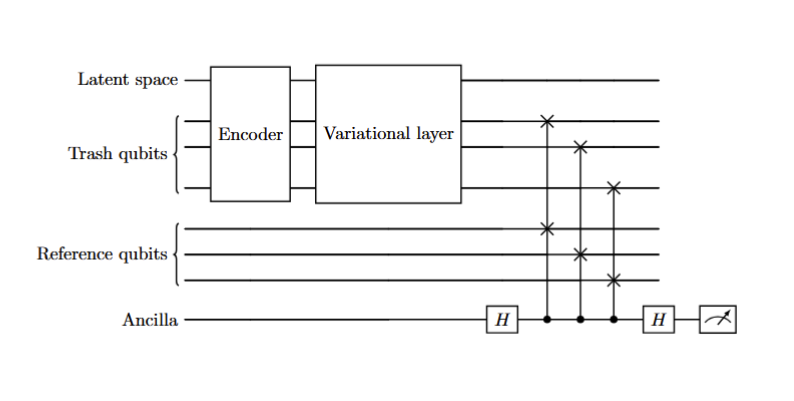

## Section: **Quantum circuit setup and encoder definition**

This code sets up a **qubit-based quantum autoencoder (QAE)** using PennyLane and PyTorch. It defines the quantum device, initializes wires for latent, trash, reference, and ancilla qubits, and implements the 1P1Q encoding scheme for jet constituents. Variational layers and a QAE circuit are also defined, along with a cost function based on fidelity for training.


In [ ]:


# --- Parámetros del circuito ---
num_particles = 10
num_latent = 2
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]


# --- 1P1Q encoding (same as in the paper) ---
def f(w):
    return 1 + (2 * np.pi / (1 + torch.exp(-w)))

def phi_circuit(w, phi, phi_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (phi - phi_jet)

def theta_circuit(w, eta, eta_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (eta - eta_jet)

def tau1_circuit(w, tau1_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (tau1_jet)

def tau2_circuit(w, tau2_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (tau2_jet)


# --- Encoder 1P1Q adapted to the new jet format ---
def encode_1p1q(jet, w):
    pt_jet = jet['pt_jet']
    eta_jet = jet['eta_jet']
    phi_jet = jet['phi_jet']
    constituents = jet['constituents']

    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        #In case of using tau variables:
        #tau1 = tau1_circuit(w, jet['tau1_jet'], c['pt'], pt_jet)
        #tau2 = tau2_circuit(w, jet['tau2_jet'], c['pt'], pt_jet)
        qml.RY(theta, wires=i)
        qml.RX(phi, wires=i)
        #qml.RY(tau1, wires=i)
        #qml.RX(tau2, wires=i)


# --- Variational layer ---
def variational_layer(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.CNOT(wires=[i, j])

        for i in range(num_particles):
            qml.RX(phi_i[layer, i], wires=i)
            qml.RZ(theta_i[layer, i], wires=i)
            qml.RY(w_i[layer, i], wires=i)


# --- QAE Circuit ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q(jet, w)
    variational_layer(theta_i, phi_i, w_i, num_layers)

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.Hadamard(wires=ancilla)
        qml.CSWAP(wires=[ancilla, trash_wire, ref_wire])
        qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)


# --- Cost function for training ---
def cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()

def encontrar_maximos_per_jet(jet):
    max_pt = jet['pt_jet']
    max_eta = jet['eta_jet']
    max_phi = jet['phi_jet']
    return max_pt, max_eta, max_phi


## Section: **Quantum autoencoder training loop**

This code initializes the trainable parameters of the quantum autoencoder and sets up an Adam optimizer. It then runs a training loop over the jets in `X_train`, computing the loss and fidelity for each jet using the QAE circuit, performing backpropagation, and updating the parameters. The average loss and fidelity per epoch are recorded and printed.


In [ ]:
import torch
import numpy as np

# --- Parameter initialisation ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)

optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=5e-3,              
    betas=(0.5, 0.999),
    eps=1e-08,
    weight_decay=0.0,    
    amsgrad=True          
)
# --- Training loop ---
num_epochs = 1
all_fidelities = []
event_fidelities = []

# --- Training ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []

    for jet in X_train:
        # Check that there are enough constituents
        if len(jet['constituents']) < num_particles:
            continue

        loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # in %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")

### **Plotting fidelity distributions**

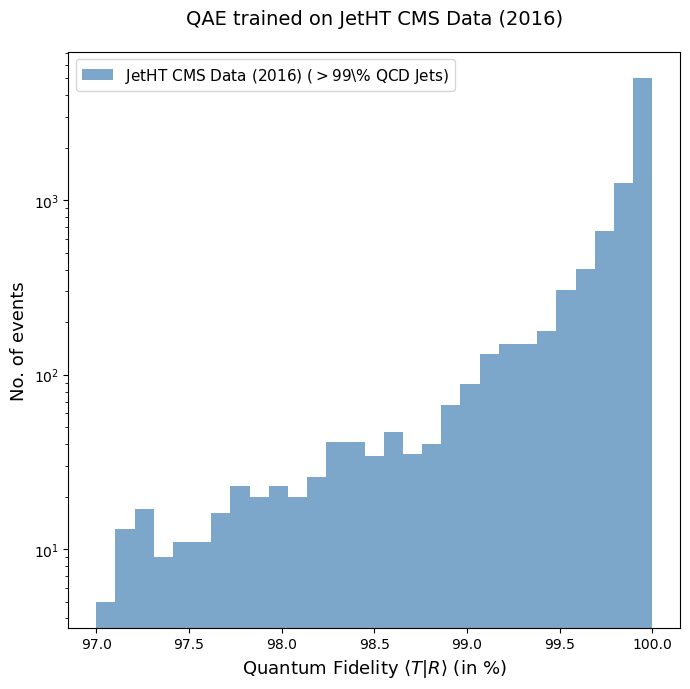

In [86]:
bins = np.linspace(97, 100, 30)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99\% QCD Jets)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_matched.png", dpi=300, bbox_inches='tight')
plt.show()

## Subsection: **Validation**

In [ ]:
event_fidelities_val = []

for jet in X_val:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_val.append(fidelity * 100) 

print(np.mean(event_fidelities_val))

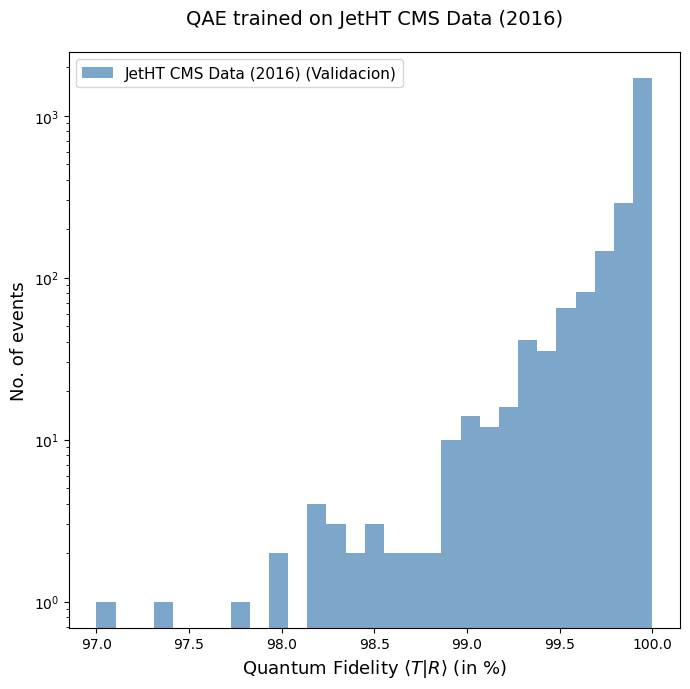

In [ ]:
bins = np.linspace(97, 100, 30)

plt.figure(figsize=(7, 7))
plt.hist(event_fidelities_val, bins=bins, histtype='stepfilled',
         color='steelblue', alpha=0.7, label=r'JetHT CMS Data (2016) (Validacion)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.legend(loc='upper left', fontsize=11)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=14, pad=20)

# Ajuste de márgenes y guardado
plt.tight_layout()
plt.savefig("qae_fidelity_distribution_validation.png", dpi=300, bbox_inches='tight')
plt.show()

## Section: **Evaluating fidelity on different jet samples (Inference)**

This code computes the fidelity of the trained quantum autoencoder on different datasets. It iterates over the inference set (`X_inf`) and labeled signal datasets (`datos_HToBB`, `datos_TTBar`, `datos_WToqq`), calculating the fidelity for each jet. The fidelities are stored along with labels to later evaluate classification performance or ROC AUC.


In [ ]:

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []

fidelidades = []
etiquetas = []


for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

Terminada prueba de validación
Terminada prueba con HToBB
Terminada prueba con TTBar
Terminada prueba con WToqq


## Section : **Plotting fidelity distribution histograms**

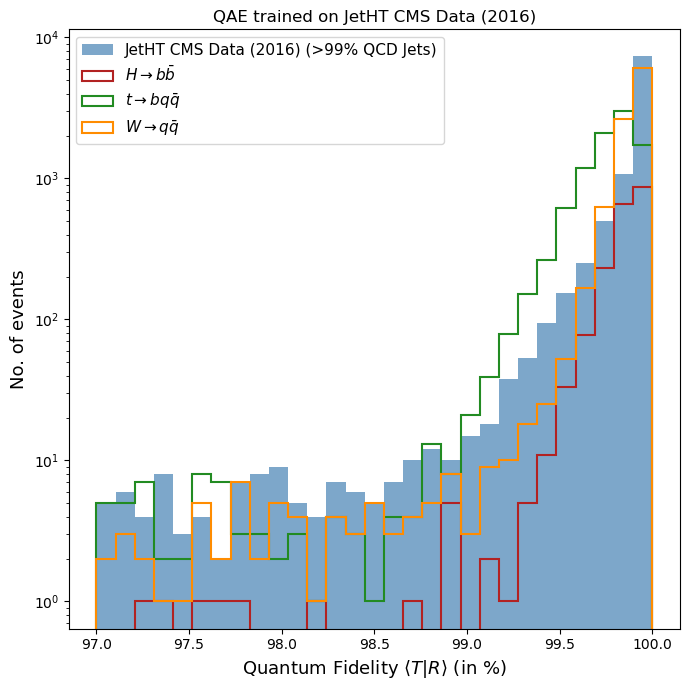

In [ ]:
plt.figure(figsize=(7, 7))

bins = np.linspace(97, 100, 30)

# --- Background: blue fill ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='steelblue', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) (>99% QCD Jets)')

# --- H → bb : red dashed line ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : green dotted line ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : orange dotted line ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1.5, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=13)
plt.ylabel(r'No. of events', fontsize=13)
plt.title(r'QAE trained on JetHT CMS Data (2016)', fontsize=12, pad=5)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
avg_fidelity_qcd = np.mean(event_fidelities_back) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_WToQQ) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_HToBB) 
print(avg_fidelity_qcd)

avg_fidelity_qcd = np.mean(event_fidelities_TTBar) 
print(avg_fidelity_qcd)

99.04088348009361
98.57099900150962
98.13572012341908


## Section: **ROC curve and AUC evaluation**

This code calculates anomaly scores as `1 - fidelity` for each jet category and computes the AUC (Area Under the Curve) for distinguishing background from different signal types (`H→bb`, `t→bqq`, `W→qq`, `QCD`). It then plots the ROC curves for each signal versus background and showing the classifier visually.


AUC (QCD vs H→bb): 0.7294
AUC (QCD vs t→bqq): 0.8286
AUC (QCD vs W→qq): 0.6643
AUC (QCD vs W→qq): 0.4063


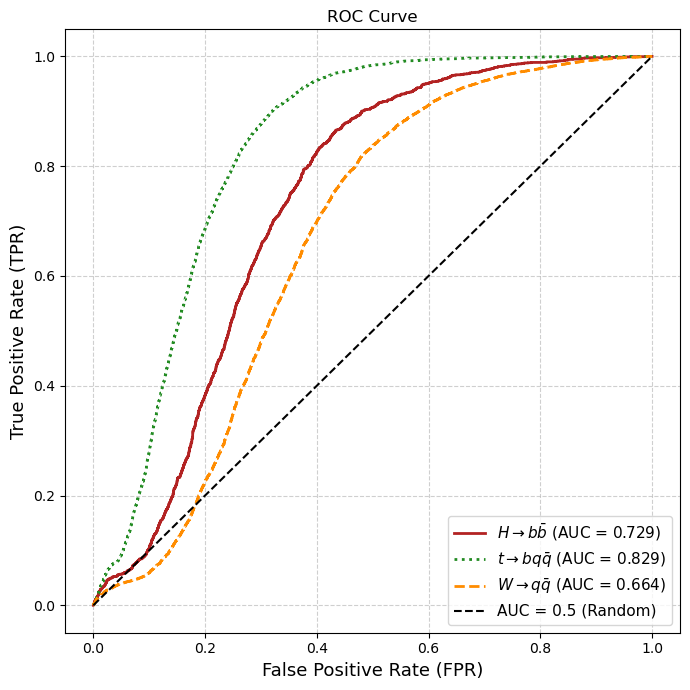

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)


# --- Calculate AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)


print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Plot ROC curves ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=2,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=2, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=2, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')
plt.xlabel(r'False Positive Rate (FPR)', fontsize=13)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=13)
plt.title(r'ROC Curve', fontsize=12, pad=5)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("qae_roc_curve_final.png", dpi=300, bbox_inches='tight')
plt.show()


⟨1-Fidelity⟩ QCD: 99.2393
AUC (QCD vs H→bb): 0.7294
AUC (QCD vs t→bqq): 0.8286
AUC (QCD vs W→qq): 0.6643


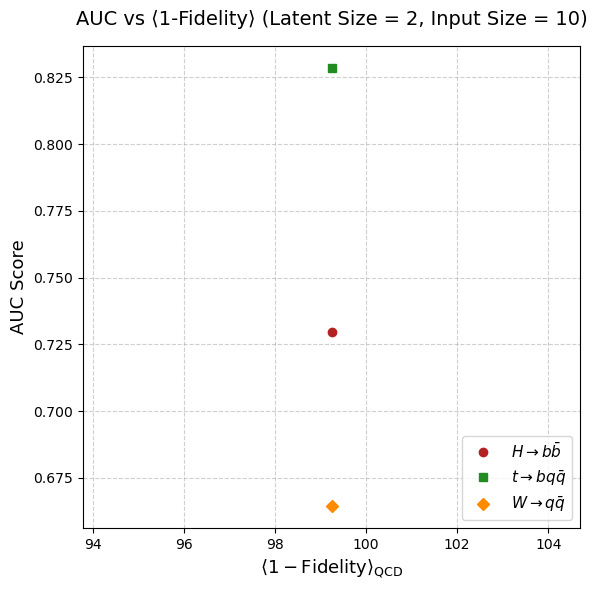

In [ ]:
# --- Fidelity data already calculated in  training ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calculate average of (1-Fidelity) of QCD ---
mean_1minus_fidelity_QCD = 1 - np.mean(anomaly_scores_back)

# --- Calculate AUCs ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"⟨1-Fidelity⟩ QCD: {mean_1minus_fidelity_QCD:.4f}")
print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Plot ---
plt.figure(figsize=(6,6))

# H→bb
plt.plot(mean_1minus_fidelity_QCD, auc_HToBB, 'o', color='firebrick', label=r'$H \rightarrow b\bar{b}$')

# t→bqq
plt.plot(mean_1minus_fidelity_QCD, auc_TTBar, 's', color='forestgreen', label=r'$t \rightarrow bq\bar{q}$')

# W→qq
plt.plot(mean_1minus_fidelity_QCD, auc_WToQQ, 'D', color='darkorange', label=r'$W \rightarrow q\bar{q}$')

# Ejes y estilos
plt.xlabel(r'$\langle 1 - \mathrm{Fidelity} \rangle_\mathrm{QCD}$', fontsize=13)
plt.ylabel('AUC Score', fontsize=13)
plt.title('AUC vs ⟨1-Fidelity⟩ (Latent Size = 2, Input Size = 10)', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig("AUC_vs_Fidelity_Latent2_Input10.png", dpi=300)
plt.show()

## Section: **Reduced QAE circuit**

This code initializes a **smaller quantum autoencoder (QAE)** with only 4 particles and 1 latent qubit. It sets up the quantum circuit, initializes trainable parameters, and uses the Adam optimizer to train the QAE on the `X_train` dataset. During training, it computes the loss and fidelity for each jet, updates parameters via backpropagation, and records average fidelities for monitoring performance. The reduced circuit allows faster experimentation with fewer qubits.


In [ ]:
# --- Circuit parameters ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

import torch
import numpy as np

# --- Parameter initialization ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)

optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=5e-3,              
    betas=(0.5, 0.999),
    eps=1e-08,
    weight_decay=0.0,    
    amsgrad=True          
)

num_epochs = 1
all_fidelities = []
event_fidelities = []


inicio = time.time()
# --- Training ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []

    for jet in X_train:
        # Check if there are enough constituents
        if len(jet['constituents']) < num_particles:
            continue

        loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)

    print(f"Epoch {epoch+1}, Loss: {1 + avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")

end = time.time()

Epoch 1, Loss: 0.0081, Avg Fidelity: 99.19%


### **Plotting fidelity distribution of the trainning step**

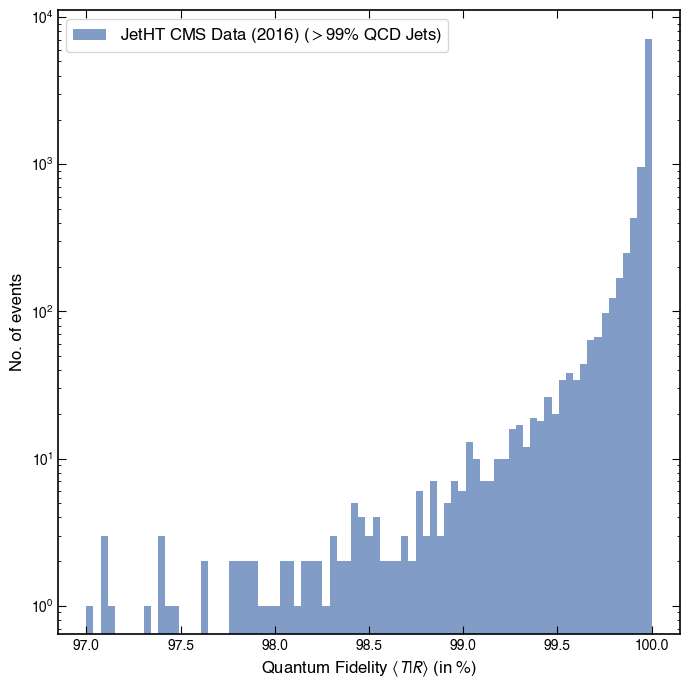

In [ ]:

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "mathtext.fontset": "stixsans",
    "axes.linewidth": 1.2,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.top": True,
    "ytick.right": True,
})



bins = np.linspace(97, 100, 80)
plt.figure(figsize=(7, 7))
plt.hist(event_fidelities, bins=bins, histtype='stepfilled',
         color='#4C72B0', alpha=0.7, label=r'JetHT CMS Data (2016) ($>$99% QCD Jets)')
plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T  | R \rangle$ (in %)', fontsize=12)
plt.ylabel(r'No. of events', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

## Section: **QAE inference and fidelity evaluation** (Reduced circuit)

This code performs **inference with the trained QAE** on different datasets: background (`X_inf`) and signal jets (`HToBB`, `TTBar`, `WToQQ`). For each jet, it computes the fidelity using the trained parameters and stores it as a measure of how well the QAE compress the input. It also records **labels** for ROC/AUC evaluation and tracks the time taken for the inference process on each dataset.


In [ ]:
event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_WToQQ = []
event_fidelities_TTBar = []
fidelidades = []
etiquetas = []

inicio = time.time()
for jet in X_inf:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

end = time.time()
tiempo_test = (end - inicio)/ 60


inicio = time.time()
for jet in datos_HToBB:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

for jet in datos_TTBar:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_TTBar.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

for jet in datos_WToqq:
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_WToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

end = time.time()
tiempo_inf = (end - inicio)/ 60

### **Plotting results** 

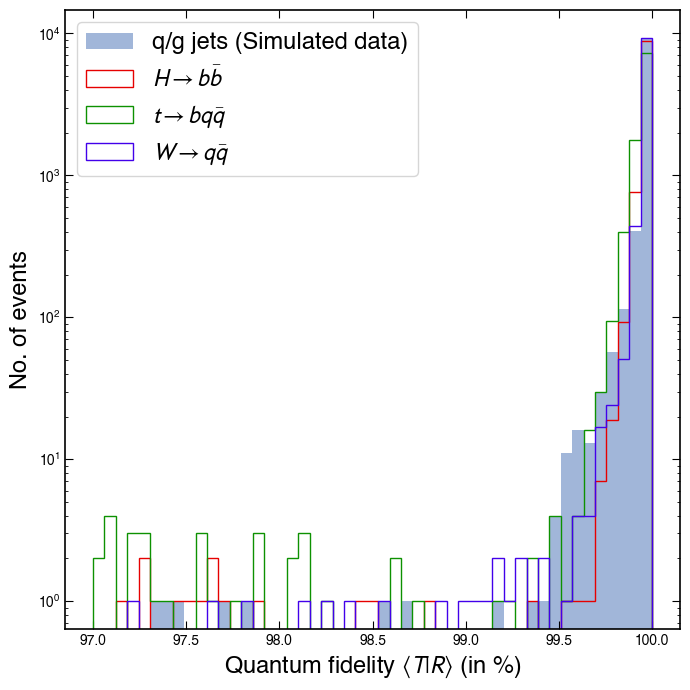

In [ ]:
plt.figure(figsize=(7, 7))


bins = np.linspace(97.0, 100, 50)

# --- Background: blue fill ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='#7998CAB6', 
         alpha=0.7, 
         label=r'q/g jets (Simulated data)')

# --- H → bb : broken red line ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='#E60000', 
         linewidth=1, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq :  green line ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color="#0D9101", 
         linewidth=1, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : violet line ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color="#4200EA", 
         linewidth=1, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum fidelity $\langle T|R \rangle$ (in %)', fontsize=17)
plt.ylabel(r'No. of events', fontsize=17)
plt.legend(loc='upper left', fontsize=17)
plt.tight_layout()
plt.show()

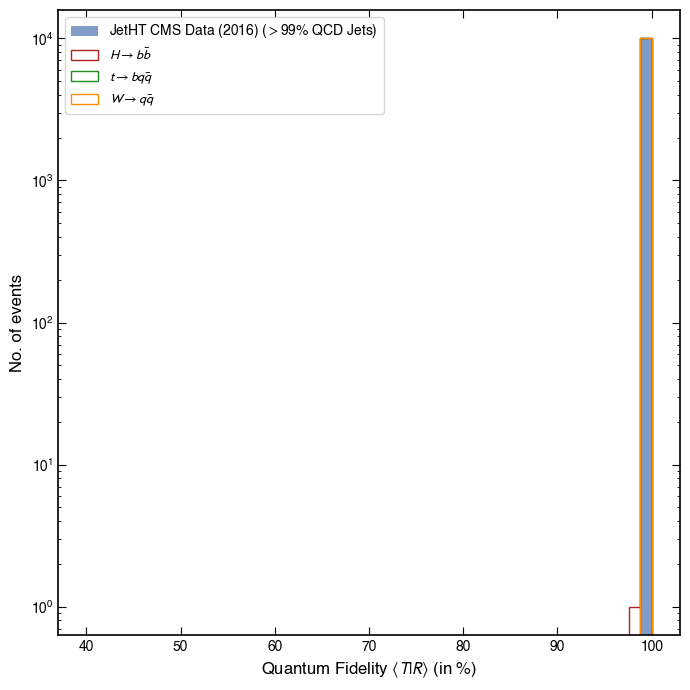

In [ ]:
plt.figure(figsize=(7, 7))

# Definir bins (de 97 a 100, como en la referencia)
bins = np.linspace(40, 100, 50)

# --- Background: relleno azul ---
plt.hist(event_fidelities_back, 
         bins=bins, 
         histtype='stepfilled', 
         color='#4C72B0', 
         alpha=0.7, 
         label=r'JetHT CMS Data (2016) ($>$99% QCD Jets)')

# --- H → bb : línea roja discontinua ---
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         histtype='step', 
         color='firebrick', 
         linewidth=1, 
         linestyle='-', 
         label=r'$H \rightarrow b\bar{b}$')

# --- t → bqq : línea verde punteada ---
plt.hist(event_fidelities_TTBar, 
         bins=bins, 
         histtype='step', 
         color='forestgreen', 
         linewidth=1, 
         linestyle='-', 
         label=r'$t \rightarrow bq\bar{q}$')

# --- W → qq : línea naranja punteada ---
plt.hist(event_fidelities_WToQQ, 
         bins=bins, 
         histtype='step', 
         color='darkorange', 
         linewidth=1, 
         linestyle='-', 
         label=r'$W \rightarrow q\bar{q}$')


plt.yscale('log')
plt.xlabel(r'Quantum Fidelity $\langle T|R \rangle$ (in %)', fontsize=12)
plt.ylabel(r'No. of events', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

## Section: ROC curves and AUC calculation

This code computes **anomaly scores** as `1 - fidelity` for the background and signal datasets. It then calculates the **ROC AUC** for each signal type against the background to quantify the QAE's anomaly detection performance. Finally, it plots the **ROC curves** for `H→bb`, `t→bqq`, and `W→qq`, including a reference random classifier line, allowing visual comparison of detection effectiveness.


AUC (QCD vs H→bb): 0.7152
AUC (QCD vs t→bqq): 0.8667
AUC (QCD vs W→qq): 0.6597


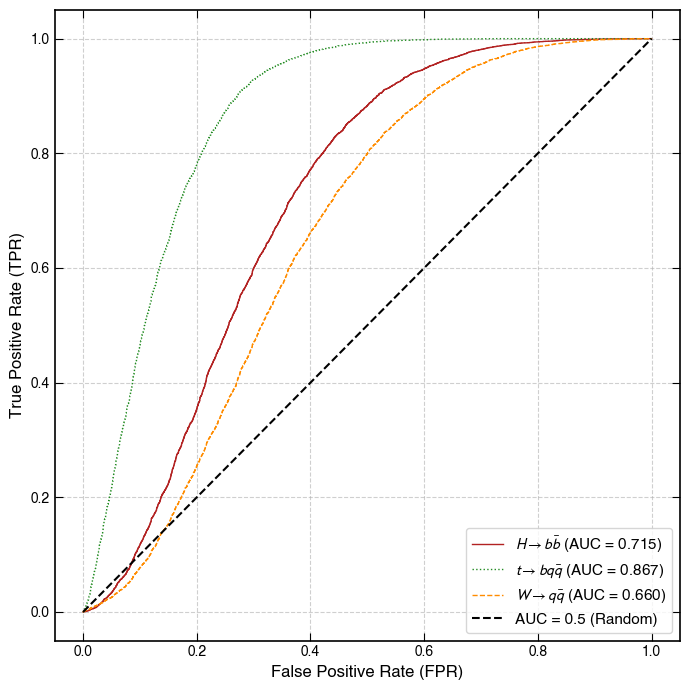

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Anomaly scores (1 - Fidelity) ---
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_TTBar = 1 - np.array(event_fidelities_TTBar)
anomaly_scores_WToQQ = 1 - np.array(event_fidelities_WToQQ)

# --- Calculate AUC ---
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_TTBar = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)

auc_WToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)

print(f"AUC (QCD vs H→bb): {auc_HToBB:.4f}")
print(f"AUC (QCD vs t→bqq): {auc_TTBar:.4f}")
print(f"AUC (QCD vs W→qq): {auc_WToQQ:.4f}")

# --- Plot ROC curves ---
plt.figure(figsize=(7, 7))

# H→bb
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, color='firebrick', linewidth=1,
         label=rf'$H \rightarrow b\bar{{b}}$ (AUC = {auc_HToBB:.3f})')

# t→bqq
fpr_TTBar, tpr_TTBar, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_TTBar)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_TTBar])
)
plt.plot(fpr_TTBar, tpr_TTBar, color='forestgreen', linewidth=1, linestyle=':',
         label=rf'$t \rightarrow bq\bar{{q}}$ (AUC = {auc_TTBar:.3f})')

# W→qq
fpr_WToQQ, tpr_WToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_WToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_WToQQ])
)
plt.plot(fpr_WToQQ, tpr_WToQQ, color='darkorange', linewidth=1, linestyle='--',
         label=rf'$W \rightarrow q\bar{{q}}$ (AUC = {auc_WToQQ:.3f})')

# Random line (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label=r'AUC = 0.5 (Random)')
plt.xlabel(r'False Positive Rate (FPR)', fontsize=12)
plt.ylabel(r'True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Section: Repeated QAE training and fidelity collection

This code runs the **QAE training and evaluation 100 times** to collect statistics. For each iteration, the circuit parameters are reinitialized, the model is trained for one epoch on the training set, and fidelities are computed for the inference set and each signal type (`H→bb`, `t→bqq`, `W→qq`). The results are stored in lists to later analyze the **distribution and variability** of the fidelities across repetitions.


In [ ]:
fil_100_back = []
fil_100_HToBB = []
fil_100_WToQQ = []
fil_100_TTBar = []

 # --- Circuit parameters ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

for i in range(100):

    w = torch.tensor(1.0, requires_grad=True)
    num_layers = 1 # Number of variational layers
    theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
    optimizer = torch.optim.Adam(
        [w, theta_i, phi_i, w_i],
        lr=5e-2,              
        betas=(0.5, 0.999),
        eps=1e-08,
        weight_decay=0.0,    
        amsgrad=True          
    )
    num_epochs = 1
    all_fidelities = []
    event_fidelities = []  # List to store event fidelities

    for epoch in range(num_epochs):
        total_loss = 0.0
        epoch_fidelities = []
        avg_fidelity = 0.0
        avg_loss = 0.0
        
        for jet in X_train:
            if len(jet['constituents']) < num_particles:
                continue
        
            loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i,  num_layers)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_fidelities.append(fidelity)
            event_fidelities.append(fidelity * 100)  # in %

        avg_loss = total_loss / len(epoch_fidelities)
        avg_fidelity = np.mean(epoch_fidelities) * 100
        all_fidelities.append(avg_fidelity)


    event_fidelities_back = []
    event_fidelities_HToBB = []
    event_fidelities_WToQQ = []
    event_fidelities_TTBar = []
    fidelidades = []
    etiquetas = []

    
    for jet in X_inf:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_back.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(0)

    

    inicio = time.time()
    for jet in datos_HToBB:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_HToBB.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(1)

    

    for jet in datos_TTBar:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_TTBar.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(1)

    

    for jet in datos_WToqq:
        if len(jet['constituents']) < num_particles:
            continue
        _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
        event_fidelities_WToQQ.append(fidelity * 100) 
        fidelidades.append(fidelity)
        etiquetas.append(1)

    

    fil_100_back.append(event_fidelities_back)
    fil_100_HToBB.append(event_fidelities_HToBB)
    fil_100_WToQQ.append(event_fidelities_WToQQ)
    fil_100_TTBar.append(event_fidelities_TTBar)

    print("Fin etapa ", i+1)

Fin etapa  1
Fin etapa  2
Fin etapa  3
Fin etapa  4
Fin etapa  5
Fin etapa  6
Fin etapa  7
Fin etapa  8
Fin etapa  9
Fin etapa  10
Fin etapa  11
Fin etapa  12
Fin etapa  13
Fin etapa  14
Fin etapa  15
Fin etapa  16
Fin etapa  17
Fin etapa  18
Fin etapa  19
Fin etapa  20
Fin etapa  21
Fin etapa  22
Fin etapa  23
Fin etapa  24
Fin etapa  25
Fin etapa  26
Fin etapa  27
Fin etapa  28
Fin etapa  29
Fin etapa  30
Fin etapa  31
Fin etapa  32
Fin etapa  33
Fin etapa  34
Fin etapa  35
Fin etapa  36
Fin etapa  37
Fin etapa  38
Fin etapa  39
Fin etapa  40
Fin etapa  41
Fin etapa  42
Fin etapa  43
Fin etapa  44
Fin etapa  45
Fin etapa  46
Fin etapa  47
Fin etapa  48
Fin etapa  49
Fin etapa  50
Fin etapa  51
Fin etapa  52
Fin etapa  53
Fin etapa  54
Fin etapa  55
Fin etapa  56
Fin etapa  57
Fin etapa  58
Fin etapa  59
Fin etapa  60
Fin etapa  61
Fin etapa  62
Fin etapa  63
Fin etapa  64
Fin etapa  65
Fin etapa  66
Fin etapa  67
Fin etapa  68
Fin etapa  69
Fin etapa  70
Fin etapa  71
Fin etapa  72
F

## Section: **Saving QAE fidelity data**

This snippet **saves the collected fidelities** from the 100 QAE runs for qubits into a compressed `.npz` file. Each signal type (`back`, `H→bb`, `W→qq`, `TTBar`) is stored separately, enabling later analysis of the **fidelity distributions** across repetitions.


In [34]:
import numpy as np

fil_100_back_qubits=fil_100_back,
fil_100_HToBB_qubits=fil_100_HToBB,
fil_100_WToQQ_qubits=fil_100_WToQQ,
fil_100_TTBar_qubits=fil_100_TTBar

np.savez(
    'fidelidades_100_QUBITS.npz',
    fil_100_back_S=fil_100_back_qubits,
    fil_100_HToBB_S=fil_100_HToBB_qubits,
    fil_100_WToQQ_S=fil_100_WToQQ_qubits,
    fil_100_TTBar_S=fil_100_TTBar_qubits
)
print("✅ Guardado como fidelidades_100_QUBITS.npz")

✅ Guardado como fidelidades_100_QUBITS.npz


## Section: Loading saved QAE fidelity data

This code **loads the previously saved fidelities** from the `fidelidades_100_QUBITS.npz` file. It retrieves each dataset (`back`, `H→bb`, `W→qq`, `TTBar`) and **removes unnecessary array dimensions** using `squeeze()` to prepare the data for analysis.


In [59]:
data = np.load('./fidelidades_100_QUBITS.npz', allow_pickle=True)
fil_100_back_3= data['fil_100_back_S']
fil_100_HToBB_3 = data['fil_100_HToBB_S']
fil_100_WToQQ_3 = data['fil_100_WToQQ_S']
fil_100_TTBar_3 = data['fil_100_TTBar_S']

fil_100_back_3 = fil_100_back_3.squeeze()
fil_100_HToBB_3 = fil_100_HToBB_3.squeeze()
fil_100_WToQQ_3 = fil_100_WToQQ_3.squeeze()
fil_100_TTBar_3 = fil_100_TTBar_3.squeeze()


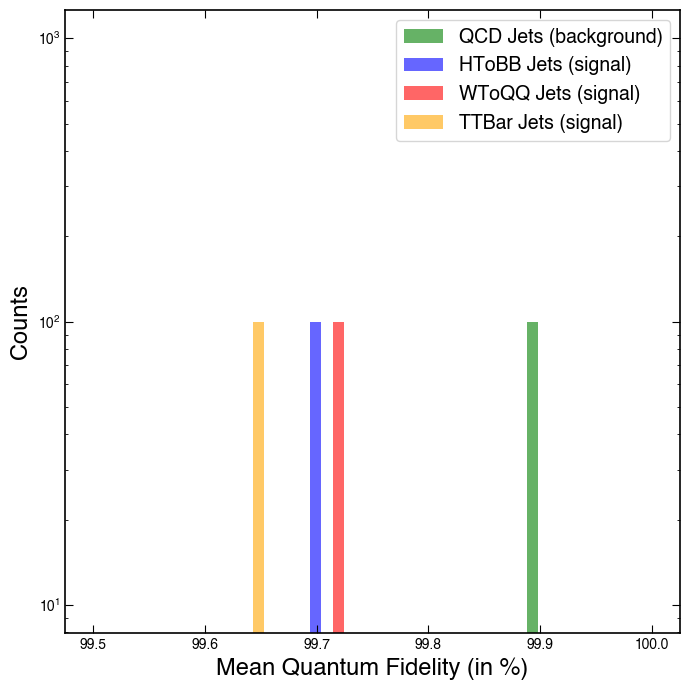

In [ ]:
means_HToBB = []
means_WToQQ = []
means_TTBar = []
means_back = []
median_HToBB = []   
median_WToQQ = []
median_TTBar = []
median_back = []

for i in range(100):
    means_back.append(np.mean(fil_100_back_3[i]))
    means_HToBB.append(np.mean(fil_100_HToBB_3[i]))
    means_WToQQ.append(np.mean(fil_100_WToQQ_3[i]))
    means_TTBar.append(np.mean(fil_100_TTBar_3[i]))
    median_back.append(np.median(fil_100_back_3[i]))
    
    median_HToBB.append(np.median(fil_100_HToBB_3[i]))
    median_WToQQ.append(np.median(fil_100_WToQQ_3[i]))
    median_TTBar.append(np.median(fil_100_TTBar_3[i]))
    median_back.append(np.median(fil_100_back_3[i]))


plt.figure(figsize=(7, 7))
bins = np.linspace(99.5, 100, 50)
plt.hist(means_back, bins=bins,  alpha=0.6, color='g', label='QCD Jets (background)', log=True)
plt.hist(means_HToBB, bins=bins,  alpha=0.6, color='b', label='HToBB Jets (signal)', log=True)
plt.hist(means_WToQQ, bins=bins,  alpha=0.6, color='r', label='WToQQ Jets (signal)', log=True)
plt.hist(means_TTBar, bins=bins,  alpha=0.6, color='orange', label='TTBar Jets (signal)', log=True)
plt.xlabel('Mean Quantum Fidelity (in %)', fontsize=17)
plt.ylabel('Counts', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

This code **prints summary statistics and anomaly scores** for the mean and median fidelities of different datasets (`BACK`, `HToBB`, `WToQQ`, `TTBar`). It calculates the **mean, median, min, max, and standard deviations** of fidelities, computes **anomaly scores**, and also shows **differences between means and medians** of the datasets for comparison.


In [ ]:
print("Anomaly Score BACKGROUND:", 1 - np.min(means_back)/100)

print("Average fidelity statistics for HToBB:")
print("Mean:", np.mean(means_HToBB))
print("Median:", np.median(median_HToBB))
print("Minimum:", np.min(means_HToBB))
print("Maximum:", np.max(means_HToBB))
print("Standard deviation of means:", np.std(means_HToBB))
print("Standard deviation of medians:", np.std(median_HToBB))
print("Anomaly Score:", 1 - np.min(means_HToBB)/100)
print()

print("Average fidelity statistics for WToQQ:")
print("Mean:", np.mean(means_WToQQ))
print("Median:", np.median(median_WToQQ))
print("Minimum:", np.min(means_WToQQ))
print("Maximum:", np.max(means_WToQQ))
print("Standard deviation of means:", np.std(means_WToQQ))
print("Standard deviation of medians:", np.std(median_WToQQ))
print("Anomaly Score:", 1 - np.min(means_WToQQ)/100)
print()

print("Average fidelity statistics for TTBar:")
print("Mean:", np.mean(means_TTBar))
print("Median:", np.median(median_TTBar))
print("Minimum:", np.min(means_TTBar))
print("Maximum:", np.max(means_TTBar))   
print("Standard deviation:", np.std(means_TTBar))
print("Anomaly Score:", 1 - np.min(means_TTBar)/100)
print()

print("Differences between means:")
print("HToBB - WToQQ:", np.mean(means_HToBB) - np.mean(means_WToQQ))
print("HToBB - TTBar:", np.mean(means_HToBB) - np.mean(means_TTBar))
print("WToQQ - TTBar:", np.mean(means_WToQQ) - np.mean(means_TTBar))
print()

print("Differences between medians:")
print("HToBB - WToQQ:", np.median(median_HToBB) - np.median(median_WToQQ))
print("HToBB - TTBar:", np.median(median_HToBB) - np.median(median_TTBar))
print("WToQQ - TTBar:", np.median(median_WToQQ) - np.median(median_TTBar))